## Step 1:
Start postgres 'Cmd + spacebar' search 'Postgres'

## Step 2: 
Start ngrok 'ngrok tcp 5432' 

## Step 3: 
Look at ngrok in terminal and find the following line 

**Forwarding tcp://0.tcp.ngrokio:14525 -> localhost:5432**         

Update the variables; 
* **ngrok_host**
* **ngrok_port**

**e.g.** for scenario above set ...

* ngrok_host='0.tcp.ngrok.io'

* ngrok_port= '14525'


began at 8.31

# Imports and clone 'MRI' generation repository from GitHub

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
!pip install keras_tuner 
import keras_tuner as kt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

!git clone https://github.com/JamesCallanan/Grad-CAM.git

%cd /content/Grad-CAM

from MRIDetails import EXPERIMENT_MODE, disease_details, SEG_MASK_KEYS, get_segment_seg_maps
from db_funcs import Experiment_Number, insert_search, insert_trial

import subprocess

def get_git_revision_short_hash() -> str:
    return subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode('ascii').strip()

def get_git_branch() -> str:
    return subprocess.check_output(['git','rev-parse','--abbrev-ref','HEAD']).decode('ascii').strip().split('* ')[-1]

current_commit_id = get_git_revision_short_hash()

%cd /content/

Mounted at /content/gdrive/
     |████████████████████████████████| 133 kB 4.5 MB/s 
Cloning into 'Grad-CAM'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 126 (delta 68), reused 80 (delta 32), pack-reused 0
Receiving objects: 100% (126/126), 25.53 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/Grad-CAM
/content


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Edit these!

In [2]:
import uuid
import os

experiment_number = Experiment_Number.EXP_2_HEATMAP_LOSS.value
json_file = "/content/gdrive/MyDrive/ME Project/New idea/Results/Experiment 2/Heatmap loss/searches.json"

search_id = str(uuid.uuid4())
search_dir = f'/content/gdrive/MyDrive/ME Project/New idea/Results/Experiment 2/Heatmap loss/{search_id}/'

num_models = 1
num_epochs = 2
#started at 15.08
database_connection_details = {
    'ngrok_host' : '8.tcp.ngrok.io',
    'ngrok_port' : '14545',
    'user' : 'james'
}

hyperparam_ranges = {
    'lr': {
            'min_val': 0.0000005,
            'max_val': 0.000005 
          }
}

#Real data

data_dir = '/content/gdrive/MyDrive/ME Project/Data/Exp2 - 95a8c3d'

exp1_train_mris_unprocessed   = np.load(os.path.join(data_dir,'exp2_train_mris_unprocessed.npy'))
exp1_train_mris_preprocessed  = np.load(os.path.join(data_dir,'exp2_train_mris_preprocessed.npy'))
exp1_train_seg_masks          = np.load(os.path.join(data_dir,'exp2_train_seg_masks.npy'))
exp1_train_label              = np.load(os.path.join(data_dir,'exp2_train_labels.npy'))

exp1_val_mris_unprocessed     = np.load(os.path.join(data_dir,'exp2_val_mris_unprocessed.npy'))
exp1_val_mris_preprocessed    = np.load(os.path.join(data_dir,'exp2_val_mris_preprocessed.npy'))
exp1_val_seg_masks            = np.load(os.path.join(data_dir,'exp2_val_seg_masks.npy'))
exp1_val_label                = np.load(os.path.join(data_dir,'exp2_val_labels.npy'))

# #Dummy data 
# data_dir = '/content/gdrive/MyDrive/ME Project/Data/Dummy data'

# exp1_train_mris_unprocessed   = np.load(os.path.join(data_dir,'dummy_train_mris_unprocessed.npy'))
# exp1_train_mris_preprocessed  = np.load(os.path.join(data_dir,'dummy_train_mris_preprocessed.npy'))
# exp1_train_seg_masks          = np.load(os.path.join(data_dir,'dummy_train_seg_masks.npy'))
# exp1_train_label              = np.load(os.path.join(data_dir,'dummy_train_labels.npy'))

# exp1_val_mris_unprocessed     = np.load(os.path.join(data_dir,'dummy_val_mris_unprocessed.npy'))
# exp1_val_mris_preprocessed    = np.load(os.path.join(data_dir,'dummy_val_mris_preprocessed.npy'))
# exp1_val_seg_masks            = np.load(os.path.join(data_dir,'dummy_val_seg_masks.npy'))
# exp1_val_label                = np.load(os.path.join(data_dir,'dummy_val_labels.npy'))

disease_classes = ['NOR', 'RV', 'HCM', 'DCM']
num_output_neurons = len(disease_classes)

# Load data and perform smell test on it

exp1_train_seg_masks

(10000, 105, 135)
Max  16
Min  0
Mean  1.2850634497354498
exp1_val_seg_masks

(3000, 105, 135)
Max  16
Min  0
Mean  1.2854806114050559
train_outside_heart_mask

(10000, 105, 135)
<class 'tuple'>
Max  True
Min  False
Mean  0.9089930440917108
val_outside_heart_mask

(3000, 105, 135)
<class 'tuple'>
Max  True
Min  False
Mean  0.9089895590828924


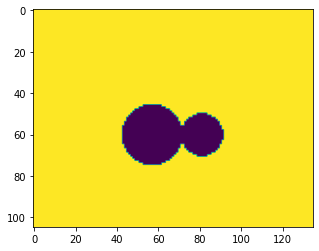

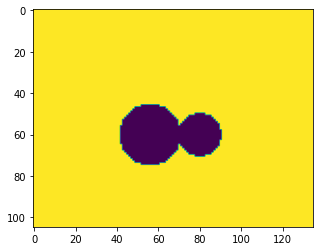

In [3]:
def print_summary(ar):
  print('Max ',np.amax(ar))
  print('Min ',np.amin(ar))
  print('Mean ',np.mean(ar))
  

train_segment_seg_masks = get_segment_seg_maps(exp1_train_seg_masks)
val_segment_seg_masks = get_segment_seg_maps(exp1_val_seg_masks)

train_outside_heart_mask  = train_segment_seg_masks['not_heart'] 
val_outside_heart_mask = val_segment_seg_masks['not_heart']

print('exp1_train_seg_masks\n')
print(exp1_train_seg_masks.shape)          
print_summary(exp1_train_seg_masks)

print('exp1_val_seg_masks\n') 
print(exp1_val_seg_masks.shape)          
print_summary(exp1_val_seg_masks)

print('train_outside_heart_mask\n')    
print(train_outside_heart_mask.shape) 
print(type(train_outside_heart_mask.shape))         
print_summary(train_outside_heart_mask)

print('val_outside_heart_mask\n')         
print(val_outside_heart_mask.shape) 
print(type(val_outside_heart_mask.shape))         
print_summary(val_outside_heart_mask)

plt.imshow(train_outside_heart_mask[0,:,:])
plt.show()

plt.imshow(val_outside_heart_mask[0,:,:])
plt.show()

In [4]:
import cv2
print(train_outside_heart_mask.shape) 
print(exp1_train_label.shape) 
print(val_outside_heart_mask.shape) 
print(exp1_val_label.shape) 

train_mask_and_labels, val_mask_and_labels = list(), list()

for i in range(train_outside_heart_mask.shape[0]):
  # Downsize heart_mask
  not_heart_mask_shrunk = cv2.resize(train_outside_heart_mask[i,:,:].astype(float), (8,6), interpolation = cv2.INTER_LINEAR)
  
  # Acquire label
  label_one_hot_code = exp1_train_label[i]
  label = np.argmax(label_one_hot_code)

  # Append row of labels to array
  label_row = np.expand_dims(np.full(shape=(not_heart_mask_shrunk.shape[0]), fill_value=label),-1)
  train_mask_and_label = np.concatenate((not_heart_mask_shrunk, label_row),-1)
  train_mask_and_labels.append(train_mask_and_label)

for i in range(val_outside_heart_mask.shape[0]):
  # Downsize heart_mask
  not_heart_mask_shrunk = cv2.resize(val_outside_heart_mask[i,:,:].astype(float), (8,6), interpolation = cv2.INTER_LINEAR)
  
  # Acquire label
  label_one_hot_code = exp1_val_label[i]
  label = np.argmax(label_one_hot_code)

  # Append row of labels to array
  label_row = np.expand_dims(np.full(shape=(not_heart_mask_shrunk.shape[0]), fill_value=label),-1)
  val_mask_and_label = np.concatenate((not_heart_mask_shrunk, label_row),-1)
  val_mask_and_labels.append(val_mask_and_label)

train_mask_and_labels = np.asarray(train_mask_and_labels)
val_mask_and_labels = np.asarray(val_mask_and_labels)

# Repeat for validation set

(10000, 105, 135)
(10000, 4)
(3000, 105, 135)
(3000, 4)


# Demonstrating that resized masks are not binary.

It would probably make more sense to pass the full masks in and resize the heatmap but I'm guessing that is harder to do using tensorflow tensor operations

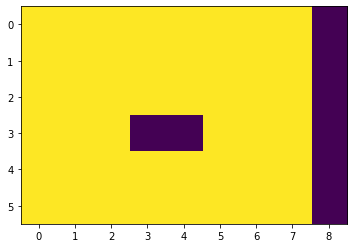

(10000, 6, 9)
0.0
3.0
0.9840581886574075


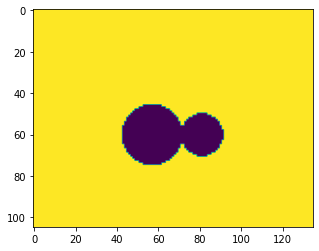

0.0
1.0
0.9089930440917108


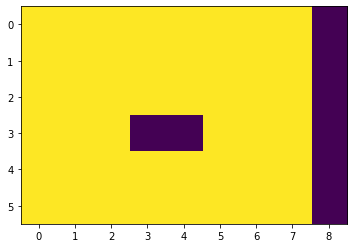

(3000, 6, 9)
0.0
3.0
0.9839832175925926


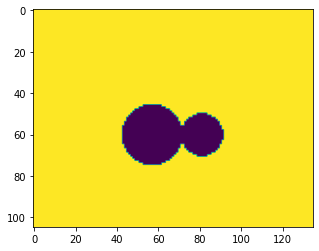

0.0
1.0
0.9089895590828924


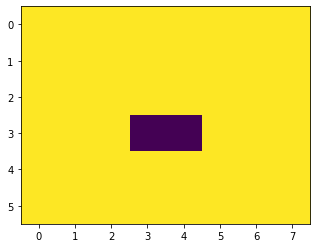

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


In [5]:
plt.imshow(train_mask_and_labels[2,:,:])
plt.show()

print(train_mask_and_labels.shape)
print(np.amin(train_mask_and_labels))
print(np.amax(train_mask_and_labels))
print(np.mean(train_mask_and_labels))


plt.imshow(train_outside_heart_mask[2,:,:])
plt.show()

print(np.amin(train_outside_heart_mask.astype(float)))
print(np.amax(train_outside_heart_mask.astype(float)))
print(np.mean(train_outside_heart_mask.astype(float)))

# print(train_mask_and_labels[2,2:5:,2:8])


plt.imshow(val_mask_and_labels[2,:,:])
plt.show()

print(val_mask_and_labels.shape)
print(np.amin(val_mask_and_labels))
print(np.amax(val_mask_and_labels))
print(np.mean(val_mask_and_labels))


plt.imshow(val_outside_heart_mask[2,:,:])
plt.show()

print(np.amin(val_outside_heart_mask.astype(float)))
print(np.amax(val_outside_heart_mask.astype(float)))
print(np.mean(val_outside_heart_mask.astype(float)))


not_heart_mask_shrunk = cv2.resize(val_outside_heart_mask[2,:,:].astype(float), (8,6), interpolation = cv2.INTER_LINEAR)
plt.imshow(not_heart_mask_shrunk)
plt.show()

print(not_heart_mask_shrunk)


# MSE and HiResCam loss 

Working solution with batch size 1

In [6]:
from tensorflow.keras.utils import to_categorical

last_conv_layer_name = 'block5_conv3'
class CustomModel(tf.keras.Model):
    def compute_loss(self, x, y, y_pred, sample_weight=None):
        # Do we need to remove the activations from the last layer?
        grad_model = tf.keras.models.Model(
            [self.inputs], [self.get_layer(last_conv_layer_name).output, self.get_layer('logits').output]#self.output]
        )

        with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(x)
          pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
        last_conv_layer_output = last_conv_layer_output[0]

        hi_res_cam_heatmap = tf.math.multiply(last_conv_layer_output, grads[0])
        hi_res_cam_heatmap = tf.reduce_mean(hi_res_cam_heatmap, -1) #Needed to average over different feature map layers
        hi_res_cam_heatmap = tf.maximum(hi_res_cam_heatmap, 0) / tf.math.reduce_max(hi_res_cam_heatmap)
        #this can be returned as a loss fn
        # return hi_res_cam_heatmap
        
        # print('np.sum(hi_res_cam_heatmap.numpy())',np.sum(hi_res_cam_heatmap.numpy()))

        # hi_res_cam_heatmap_np = cv2.resize(hi_res_cam_heatmap_np, (135,105), interpolation = cv2.INTER_LINEAR)

        batch_index = 0
        not_heart_mask = y[batch_index,:,:8]
        # print('not_heart_mask',not_heart_mask)
        heatmap_loss = tf.multiply(hi_res_cam_heatmap, not_heart_mask)
        heatmap_loss = tf.reduce_mean(heatmap_loss)
        # print('heatmap_loss',heatmap_loss)

        arbitrary_row_in_label_column = 0
        label_row = 8
        y_labels = y.numpy()[batch_index,arbitrary_row_in_label_column,label_row] #can pick any row in the 136th column to get label
        y_labels = to_categorical(y_labels, num_classes=4)
        y_labels = tf.cast(y_labels, tf.float32)
        
        y_pred = tf.cast(y_pred[0,:], tf.float32)

        squared_difference_loss = tf.square(y_labels - y_pred)
        squared_difference_loss = tf.reduce_mean(squared_difference_loss)
        # print('squared_difference_loss',squared_difference_loss)

        # reduced_mean = tf.reduce_mean(squared_difference, axis=-1)
        loss = squared_difference_loss + heatmap_loss
        
        return loss

class CustomMSE(tf.keras.metrics.MeanMetricWrapper):
  def __init__(self, name='custom_MSE', dtype=None, threshold=0.5):
    super(CustomMSE, self).__init__(
        custom_MSE, name, dtype=dtype, threshold=threshold)


class CustomAccuracy(tf.keras.metrics.MeanMetricWrapper):
  def __init__(self, name='custom_accuracy', dtype=None, threshold=0.5):
    super(CustomAccuracy, self).__init__(
        custom_accuracy, name, dtype=dtype, threshold=threshold)

def custom_accuracy(y_true, y_pred, threshold=0.5):
  batch_index = 0
  label_row = 8
  arbitrary_row_in_label_column = 0
  y_true = y_true[batch_index,arbitrary_row_in_label_column,label_row]
  y_pred = tf.convert_to_tensor(y_pred)
  y_pred = tf.cast(tf.argmax(y_pred[0]),dtype=tf.float32) #y_pred[0] as y_pred has shape (1,4) number between 0 and 3 inclusive
  return tf.equal(y_true, y_pred)

  
def custom_MSE(y_true, y_pred, threshold=0.5):
  batch_index = 0
  label_row = 8
  arbitrary_row_in_label_column = 0
  y_true = y_true[batch_index,arbitrary_row_in_label_column,label_row]
  y_true = to_categorical(y_true, num_classes=4)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred[0,:], tf.float32)
  print('y_true', y_true)
  print('y_pred', y_pred)
  squared_difference_loss = tf.square(y_true - y_pred)
  print('squared_difference_elements', squared_difference_loss)
  squared_difference_loss = tf.reduce_mean(squared_difference_loss)
  print('mean_squared_difference_loss', squared_difference_loss)
  return squared_difference_loss

# CustomMSE loss appears to work
Question is can we pass self into this function somehow?

Probably not if using MeanMetricWrapper as this assumes a certain format ...

But at least could choose the best which gave lowest MSE loss

Can't pass the x_inputs into a metric unless I use a callback? could be a misinterpretation of what fchollet said . 
 Can you use callback metric with keras tuner? Probably?
https://github.com/keras-team/keras/issues/4506

In [7]:
tuner_log_filepath = os.path.join(search_dir, 'tuner_search_logs')
os.makedirs(search_dir)
model_folder_path = os.path.join(search_dir, 'Models/')
os.makedirs(model_folder_path)
os.path.join(search_dir, 'tb/')
tensorboard_folder_path = os.path.join(search_dir, 'tb/')
keras_tuner_path = os.path.join(search_dir, 'kt/')


def get_model(lr):
  model = VGG16(include_top=False, input_shape=(105, 135,3))
  for layer in model.layers:
    layer.trainable = True
  x = Flatten()(model.layers[-1].output)
  x = Dense(100, activation='relu', kernel_initializer='he_uniform')(x)  
  logits = Dense(num_output_neurons, activation=None, name='logits')(x)
  output = tf.keras.activations.sigmoid(logits)
  model = CustomModel(inputs=model.inputs, outputs=output)
  opt = Adam(learning_rate=lr)
  model.compile(optimizer=opt, metrics=[CustomAccuracy(), CustomMSE()], run_eagerly=True)
  return model

def build_model(hp):
    lr = hp.Float("lr", min_value=hyperparam_ranges['lr']['min_val'], max_value=hyperparam_ranges['lr']['max_val'], sampling="log")
    model1 = get_model(lr=lr )
    return model1

tuner2 = kt.BayesianOptimization(
    hypermodel=build_model,
    objective= kt.Objective('val_custom_MSE', direction="min"),
    max_trials=num_models,
    executions_per_trial=1,
    overwrite=True,
    directory= keras_tuner_path,
    project_name="keras_tuner",
)

import sys
# sys.stdout = open(tuner_log_filepath, 'w')
tuner2.search(x = exp1_train_mris_preprocessed, y=train_mask_and_labels , validation_data=(exp1_val_mris_preprocessed, val_mask_and_labels), batch_size=1, epochs=num_epochs, callbacks=[tf.keras.callbacks.TensorBoard(tensorboard_folder_path)])
# sys.stdout.close()


Trial 1 Complete [01h 05m 25s]
val_custom_MSE: 1.3898161910219642e-07

Best val_custom_MSE So Far: 1.3898161910219642e-07
Total elapsed time: 01h 05m 25s
INFO:tensorflow:Oracle triggered exit


In [8]:
import json
import os

if os.path.isfile(json_file):
  a_file = open(json_file, "r")
  json_object = json.load(a_file)
  a_file.close()

  list_of_string_search_numbers = list(json_object.keys())
  list_of_integer_search_numbers = list(map(int, list_of_string_search_numbers))

  max_search_number = max(list_of_integer_search_numbers)
  current_search_number = max_search_number + 1

else:
  current_search_number = 0
  json_object = {}

json_object[current_search_number] = search_id

a_file = open(json_file, "w")
json.dump(json_object, a_file)
a_file.close()


In [9]:
best_trials = tuner2.oracle.get_best_trials(num_models)
best_models = tuner2.get_best_models(num_models)
print(best_models[0])
print(best_trials[0])

In [10]:
tuner_search = {
                  'search_id' :  search_id, 
                  'experiment_number' : experiment_number,
                  'num_models' :  num_models,
                  'num_epochs' :  num_epochs,
                  'hyperparam_ranges' :  str(hyperparam_ranges),
                  'git_commit_id' :  current_commit_id,
                  'data_path' :  data_dir,
                  'tensorboard_folder_path' :  tensorboard_folder_path,
                  'keras_tuner_folder_path' :  keras_tuner_path,
                  'search_duration_seconds' : 0
                }

# #insert tuner search
insert_search(tuner_search, database_connection_details)

best_trials = tuner2.oracle.get_best_trials(num_models)
best_models = tuner2.get_best_models(num_models)

for model, trial in zip(best_models, best_trials):
    kt_trial_id = trial.trial_id

    #compute metrics
    hyperparams = trial.hyperparameters

    model_path = os.path.join(model_folder_path, kt_trial_id)
    model.save_weights(model_path) # Need to save weights as we lose custom loss and accuracy metrics when saving model

    # val_results = model.evaluate(x = exp1_val_mris_preprocessed, y=val_mask_and_labels )
    # #val_results[0] corresponds to custom loss metric which is 0 as we can't access gradients
    # #val_results[1] and val_results[2] correspond to metrics CustomAccuracy and CustomMSE
    # val_loss, val_acc = val_results[1], val_results[0]
    # train_results = model.evaluate(x = exp1_train_mris_preprocessed, y=train_mask_and_labels )
    # train_loss, train_acc = train_results[1], train_results[0]

    #gathering into one dict

    val_loss = 500.0
    train_loss = 500.0
    val_acc = 500.0
    train_acc = 500.0

    trial = {
              'val_loss' : val_loss,
              'val_acc' : val_acc,
              'train_loss' : train_loss,
              'train_acc' : train_acc,
              'kt_trial_id'  : kt_trial_id,
              'search_id' : search_id, 
              'model_path': model_path,
              'learning_rate' : hyperparams.values['lr'],
            }

    ##insert to DB##
    insert_trial(trial, database_connection_details)

In [11]:
print('Hello')

Hello


In [13]:
print(search_id)

d6825467-376b-4c29-8fc2-892d4697f095


In [12]:
print('out')

out
